# **Classification of COVID Image Data Multiclass CT Scan**

## Hands On Data Science Trainee - Jakarta Smart City

**Description:**
* Development of COVID Multiclass CT scan image classification using a Machine Learning model, especially the Deep Learning approach with the Transfer Learning architecture of the EfficientNetB2 Convolutional Neural Network.
* The dataset contains 4173 CT scan image data of the lungs (Chest CT Scan) with 3 different classes including Covid, Healthy, Others.

**Dataset details:**

The dataset comes from https://www.kaggle.com/datasets/plameneduardo/a-covid-multiclass-dataset-of-ct-scans which contains 4173 COVID CT scan images in png format
* 758 CT scans for healthy patients (Healthy)
* 2168 CT scans for patients infected with SASR-CoV-2 or COVID-19 (Covid)
* 1247 CT scans for patients with other lung disorders (Others)
* TOTAL: 4173 CT scans for 210 Sao Paulo - Brazil patients (average 20 CT scans per patient).



# **Preparation**
### (Check Python Version, GPU, Install, Import Library, Check Dataset)

### Check python and GPU versions

In [1]:
!python --version

Python 3.7.10


In [2]:
!nvidia-smi #show the allocated GPU

Sun Jun 18 11:19:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     8W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

### Install the EfficientNet Pre-trained Model

In [3]:
!pip install efficientnet

     |████████████████████████████████| 50 kB 2.8 MB/s 


### Import Library 
Import the required libraries

In [4]:
import matplotlib.pyplot as plt
import tensorflow

import numpy as np # linear algebra
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import KFold
import random
import sys
import pandas
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import os
import gc

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from efficientnet.tfkeras import EfficientNetB2

### Check Datasets

In [5]:
# Check dataset
base_dir = '/kaggle/input/covid-19-ct/New_Data_CoV2'
ct_scans = os.listdir(base_dir)
ct_scans

['Healthy', 'Covid', 'Others']

In [6]:
# Total dataset
total = 0

for i in ct_scans:
    dir = os.path.join(base_dir, i)
    num = len(os.listdir(dir))
    print(i+':', num, 'data')
    total = total + num

print('__________________________________')
print('\nTotal:', total, 'data')

Healthy: 758 data
Covid: 2168 data
Others: 1247 data
__________________________________

Total: 4173 data


# **Pre-Processing**

### Dataset Splitting

The dataset contains 4173 CT scan image data of the lungs with 3 classes:
* Covid (2168 data)
* Healthy (758 data)
* Others (1247 data)

The data is divided by a ratio of 0.80 for training data, 0.1 for validation data, and 0.1 for testing data. So that:
* Training (3335 data)
* Validation (415 data)
* Testing (215 data)

In [7]:
!pip install split-folders

In [8]:
# Split folder to divide the dataset into training, validation, and testing data
import splitfolders
splitfolders.ratio(base_dir, output="./train-test", seed=42, ratio=(.80, 0.1, 0.1))

Copying files: 4173 files [00:29, 139.16 files/s]


In [9]:
# dataset directory
train_dir = '/kaggle/working/train-test/train'
val_dir = '/kaggle/working/train-test/val'
test_dir = '/kaggle/working/train-test/test'

# **Data Augmentation (Pre-processing)**

* Data augmentation is a method used to avoid overfitting problems and to increase the number of available datasets
* Initialize the required hyperparameters such as learning rate, batch, epoch, and others.
* Pre-processing: transformation of raw data before it is entered or used into the model (rescale, etc.).
* Cropping or resizing, by changing the data size to 224 x 224 x 3 pixels so that all data has the same size.
* Data augmentation to overcome overfitting and improve the accuracy of the models used (rotation, shift, shear, zoom, flip, fill mode)
* Training data is then randomized to generalize the model and reduce overfitting.

In [10]:
# Hyperparameter Initiation
input_tensor  = Input(shape=(224,224,3))
learning_rate = 0.0001
epochs        = 60
image_size    = (224, 224)
batch_size    = 16

# Data augmentation on training data
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=15, 
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip = True,
                    fill_mode='nearest')

# Rescale on validation data
val_datagen = ImageDataGenerator(rescale=1./255)

#flow_from_directory() method takes a path of a directory and generates 
# batches of augmented data.

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=image_size,  
                    batch_size=batch_size,
                    shuffle=True,
                    class_mode='categorical',
                    #subset='training'
)

validation_generator = val_datagen.flow_from_directory(
                    val_dir,
                    target_size=image_size,  
                    batch_size=batch_size,
                    shuffle=False,
                    class_mode='categorical', 
                    #subset='validation'
)

Found 3336 images belonging to 3 classes.
Found 415 images belonging to 3 classes.


### Explore some training data

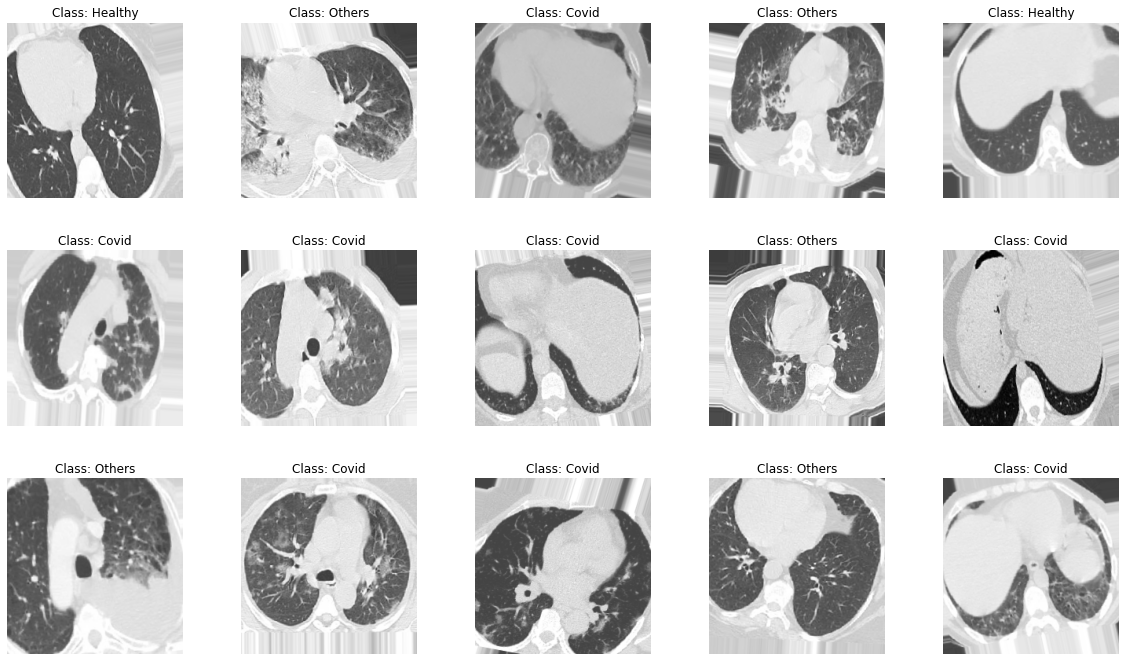

In [11]:
labels = [k for k in train_generator.class_indices]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

# **Building Models with CNN (Convolutional Neural Network)**

* Model designed using CNN transfer learning technique (Xception architecture). Xception architecture is used as the base model which is then added with GlobalAveragePooling2D layer, Dense layer with ReLU activation function, dropout layer, and BatchNormalization at the end.
* Dropout and BatchNormalization are used to prevent the model from overfitting.

In [12]:
def getModel():
        base_model = EfficientNetB2(weights='noisy-student',include_top=False, input_tensor=input_tensor)
        base_model = base_model.output
        model = GlobalAveragePooling2D()(base_model)
        model = Dense(256, activation='relu')(model)
        model = Dropout(0.2)(model)
        model = BatchNormalization()(model)
        model = Dense(3, activation='softmax')(model)
        model = Model(inputs=input_tensor, outputs=model)
 
        for layer in model.layers:
            layer.trainable = True
      
            model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])
  
        return model

model=getModel()

31784960/31782304 [==============================] - 0s 0us/step


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

# **Callbacks**

In [14]:
# Save output model
model_file_path='./efficientnet_model.hdf5'

# This callback will stop the training when there is no improvement in
# the val_loss for 20 consecutive epochs
early_stop = EarlyStopping(patience=20, 
                          verbose=1, 
                          mode='auto')

# Reduce learning rate when a metric has stopped improving.
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=10,
                                  verbose=1,factor=0.2, min_lr=0.000001)

# save the best model (best Validation Accuracy)
checkpoints = ModelCheckpoint(model_file_path,monitor='val_accuracy',
                                  mode='max',save_best_only=True)

# Model Training

In [15]:
model=getModel()

# fit model
steps_per_epoch=train_generator.n/batch_size
validation_steps=validation_generator.n/batch_size

history = model.fit(
              train_generator, 
              steps_per_epoch=steps_per_epoch,  # how many batches will be executed in each epoch
              epochs=epochs,
              validation_data=validation_generator, # displays the accuracy of validation data testing
              validation_steps=validation_steps,  # how many batches will be executed in each epoch
              callbacks=[early_stop,learn_control,checkpoints],
              verbose=1)

Epoch 1/60
208/208 [==============================] - 97s 355ms/step - loss: 1.1453 - accuracy: 0.5035 - val_loss: 0.8767 - val_accuracy: 0.5904
Epoch 2/60
208/208 [==============================] - 71s 339ms/step - loss: 0.7717 - accuracy: 0.6875 - val_loss: 0.8717 - val_accuracy: 0.6145
Epoch 3/60
208/208 [==============================] - 71s 341ms/step - loss: 0.6130 - accuracy: 0.7471 - val_loss: 0.7462 - val_accuracy: 0.6867
Epoch 4/60
208/208 [==============================] - 70s 337ms/step - loss: 0.5437 - accuracy: 0.7981 - val_loss: 0.3034 - val_accuracy: 0.8916
Epoch 5/60
208/208 [==============================] - 71s 341ms/step - loss: 0.4164 - accuracy: 0.8390 - val_loss: 0.6178 - val_accuracy: 0.8217
Epoch 6/60
208/208 [==============================] - 74s 352ms/step - loss: 0.3958 - accuracy: 0.8607 - val_loss: 0.2897 - val_accuracy: 0.9036
Epoch 7/60
208/208 [==============================] - 73s 351ms/step - loss: 0.3595 - accuracy: 0.8574 - val_loss: 0.4463 - val_ac

# Model Evaluation

### Plot Model Accuracy and Model Loss
To evaluate Underfitting or Overfitting. Visualize training accuracy vs. validation accuracy and training loss vs. validation loss over several epochs to determine whether the model has been sufficiently trained.

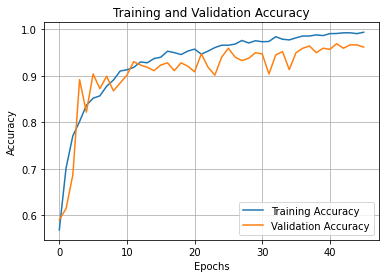

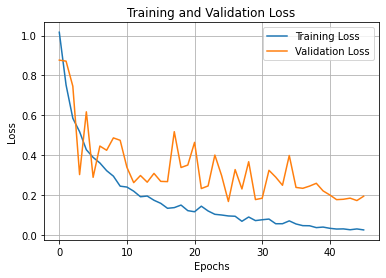

In [16]:
# Plot Model Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Model Loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plt.plot(epochs, loss_train,  label='Training Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Confusion Matrix and Classification Report
* Confusion Matrix is a table that is often used to describe the performance of a classification model on a set of test data (here is validation data) whose true value is known.
* Classification Report is used to measure the prediction quality of the classification algorithm. How many predictions were Right and how many were Wrong.

26/26 [==============================] - 3s 99ms/step - loss: 0.1779 - accuracy: 0.9687
Train Accuracy: 99.91%
Validation Accuracy: 96.87%
25/25 [==============================] - 4s 90ms/step


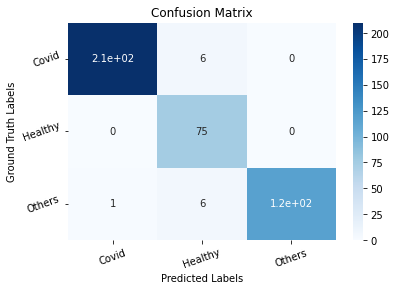

<Figure size 216x216 with 0 Axes>


              ---Classification Report---

              precision    recall  f1-score   support

       Covid     0.9953    0.9722    0.9836       216
     Healthy     0.8621    1.0000    0.9259        75
      Others     1.0000    0.9435    0.9710       124

    accuracy                         0.9687       415
   macro avg     0.9524    0.9719    0.9602       415
weighted avg     0.9726    0.9687    0.9694       415



In [17]:
#Load model
model.load_weights(model_file_path)
validation_generator.reset()

# Model evaluation
scores_train = model.evaluate(train_generator,verbose=1)
scores_validation = model.evaluate(validation_generator, verbose=1)
print("Train Accuracy: %.2f%%" % (scores_train[1]*100))
print("Validation Accuracy: %.2f%%" % (scores_validation[1]*100))

# Model Prediction
pred=model.predict(validation_generator, steps=validation_steps, verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

actual_class = validation_generator.classes
actual = [labels[k] for k in actual_class]
val_labels = [fn.split('/')[0] for fn in actual]

target_names=list(validation_generator.class_indices.keys())

# Confusion Matrix
cm=confusion_matrix(val_labels, predictions)
    
# Confusion Matrix Figure
fig = sns.heatmap(cm, annot=True, cmap = "Blues")
fig.set(title = 'Confusion Matrix', xlabel='Predicted Labels', ylabel='Ground Truth Labels')
fig.set_xticklabels(target_names,rotation=20)
fig.set_yticklabels(target_names,rotation=20)
plt.figure(figsize=(3,3))
plt.show(fig)

# Classification Report
cr=classification_report(val_labels, predictions, digits=4)
print("\n              ---Classification Report---\n")
print(cr)

# Testing Model
Testing the model using test data (testing data) to determine the accuracy of the model on the test data.

Found 420 images belonging to 3 classes.
26/26 [==============================] - 5s 110ms/step
[[207   3   7]
 [  0  76   1]
 [  1   3 122]]


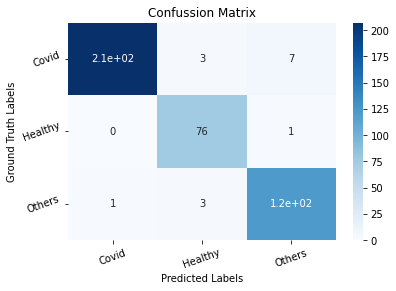

<Figure size 216x216 with 0 Axes>


              ---Classification Report---

              precision    recall  f1-score   support

       Covid     0.9952    0.9539    0.9741       217
     Healthy     0.9268    0.9870    0.9560        77
      Others     0.9385    0.9683    0.9531       126

    accuracy                         0.9643       420
   macro avg     0.9535    0.9697    0.9611       420
weighted avg     0.9656    0.9643    0.9645       420



In [18]:
# Rescale
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size=image_size, 
                 batch_size=batch_size,
                 class_mode=None,
                 shuffle=False)
test_steps=test_generator.n/batch_size
test_generator.reset()

#Calling the saved model for making predictions
model_file='./efficientnet_model.hdf5'
tl_img_aug_cnn = load_model(model_file)
pred=tl_img_aug_cnn.predict(test_generator,
                            verbose=1,
                            steps=test_steps)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results_test.csv",index=False)
target_names=list(validation_generator.class_indices.keys())
test_labels = [fn.split('/')[0] for fn in filenames]
cm=confusion_matrix(test_labels,predictions)
print(cm)

    
#Confussion Matrix Figure
fig = sns.heatmap(cm, annot=True, cmap = "Blues")
fig.set(title = 'Confussion Matrix', xlabel='Predicted Labels', ylabel='Ground Truth Labels')
fig.set_xticklabels(target_names,rotation=20)
fig.set_yticklabels(target_names,rotation=20)
plt.figure(figsize=(3,3))
plt.show(fig)

#Classification Report
cr=classification_report(test_labels, predictions, digits=4)
print("\n              ---Classification Report---\n")
print(cr)